# Oanda Demo Trading Notebook

## Packages

### Normal Packages

In [1]:
import numpy as np
import pandas as pd

import yaml
import json

import sys
import time
import math
import pytz
import datetime
import winsound
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Oanda Packages

In [2]:
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.trades as trades
import oandapyV20.endpoints.pricing as pricing
import oandapyV20.endpoints.accounts as accounts
import oandapyV20.endpoints.transactions as trans
import oandapyV20.endpoints.positions as positions

import oandapyV20.definitions.pricing as defpricing

import oandapyV20.endpoints.instruments as instruments

from oandapyV20.contrib.requests import (MarketOrderRequest, StopLossDetails)

### Custom packages

In [3]:
from utils.tools import get_date_time
from utils.tools import get_prices
from utils.tools import calc_duration

## Tools

In [5]:
def make_order(accountID, stop_price, instrument, units):
    stopLossOnFill = StopLossDetails(price=stop_price)

    ordr = MarketOrderRequest(
        instrument = instrument,
        units=units,
        stopLossOnFill=stopLossOnFill.data)

    r = orders.OrderCreate(accountID, data=ordr.data)
    rv = api.request(r)
    return(rv)

In [6]:
def close_order(accountID, order_type, instrument):
    data_long = {"longUnits": "ALL"}
    data_short = {"shortUnits": "ALL"}
    
    if order_type == 'long':
        data = data_long
    elif order_type == 'short':
        data = data_short
        
    r = positions.PositionClose(accountID=accountID,
                                instrument=instrument,
                                data=data)
    rv = api.request(r)
    return(rv)

In [18]:
def get_weights(s):
    n = 1/s
    val = 0
    val_list = []
    for i in range(s):
        val += n
        val_list.append(val)
    val_list = np.array(val_list)
    tot = sum(val_list)
    val_list = val_list/tot
    return(val_list)

## API Setup

Read from config file

In [15]:
temp_file = 'config/access_keys.yaml'
with open(temp_file) as temp_file:
    config = yaml.load(temp_file)
    
temp_file = 'config/currencies.yaml'
with open(temp_file) as temp_file:
    currencies = yaml.load(temp_file)

temp_file = 'config/stepped_loss.yaml'
with open(temp_file) as temp_file:
    loss_limits = yaml.load(temp_file)

In [16]:
access_token = config['oanda_demo_account']['token']
accountID = config['oanda_demo_account']['account_id']
api = API(access_token = access_token)

## Code Engine

# Log these inputs as well

In [17]:
# max_loss_num = 1
# full_loss_ratio = 10


instrument="EUR_USD"
pip_size = currencies['currs'][instrument]['pip_size']
pip_gap = currencies['currs'][instrument]['pip_gap']

profit_target_num  = 0.5
price_allowed_buffer = 0.5 
loss_limit_num = 25


target_num = 3
min_count = 2
min_count_mulitplier = 1


iter_num = 300
dir_min_trans_multiplier_long = 1
dir_min_trans_multiplier_short = 0.5

run_min_trans_multiplier = 25
dir_recalc_multiplier = 5

num_of_bets = 10

In [48]:
def run_wma(short_moving_window, long_moving_window):
    params = {'instruments': instrument}
    order_flag = 'not_ordered'
    r = pricing.PricingStream(accountID=accountID, params=params)
    rv = api.request(r)

    short_wma = 0
    short_flag = True
    short_list = collections.deque([])
    short_wma_list = collections.deque([])
    short_weights = get_weights(short_moving_window)

    long_wma = 0
    long_flag = True
    long_list = collections.deque([])
    long_wma_list = collections.deque([])
    long_weights = get_weights(long_moving_window)

    tick_list = collections.deque([])

    list_ready = False
    old_direction =  'none'
    
    for i, resp in tqdm(enumerate(rv)):        
        resp_type = resp['type']       

        if resp_type == 'HEARTBEAT': # Heart beat response to keep the api connection alive (Avoid timeout)
            pass

        elif resp_type == 'PRICE' and order_flag == 'not_ordered': # Check if we are yet to make the order               
            date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
            sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response                      
            
            if len(short_list) < short_moving_window:
                short_list.append(tick_price)

            if short_flag and len(short_list) == short_moving_window:
                short_wma = sum(np.array(short_list)*short_weights)
                short_flag =  False

            if short_flag == False and len(short_list) == short_moving_window:
                short_list.popleft()   
                short_list.append(tick_price) 
                short_wma = sum(np.array(short_list)*short_weights)

            if len(long_list) < long_moving_window:
                long_list.append(tick_price)

            if long_flag and len(long_list) == long_moving_window:
                long_wma = sum(np.array(long_list)*long_weights)
                long_flag =  False

            if long_flag == False and len(long_list) == long_moving_window:
                long_list.popleft()   
                long_list.append(tick_price) 
                long_wma = sum(np.array(long_list)*long_weights)   
                list_ready = True

            if list_ready:
                if short_wma > long_wma:
                    direction = 'positive'

                elif short_wma < long_wma:
                    direction = 'negative'

                elif short_wma == long_wma:
                    direction = 'no direction'
            
            if list_ready and old_direction != direction:
                print(f'Direction changed to {old_direction}')
                old_direction = direction
                    
    #winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)   
    return(short_wma_list, long_wma_list, tick_list)

In [49]:
short_wma_list, long_wma_list, tick_list = run_wma(short_moving_window = 5, long_moving_window = 200)

241it [03:30,  1.08it/s]

Direction changed to none


251it [03:51,  2.11s/it]

Direction changed to positive


252it [03:52,  1.70s/it]

Direction changed to negative


253it [03:52,  1.27s/it]

Direction changed to positive


254it [03:52,  1.02it/s]

Direction changed to negative


257it [03:54,  1.61it/s]

Direction changed to positive


259it [03:54,  1.98it/s]

Direction changed to negative


297it [04:29,  1.10it/s]


KeyboardInterrupt: 

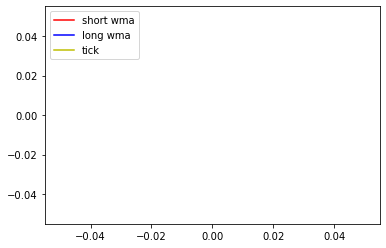

<Figure size 1440x720 with 0 Axes>

In [50]:
plt.plot(short_wma_list, 'r' ,label="short wma")
plt.plot(long_wma_list,'b' ,label="long wma")
plt.plot(tick_list, 'y' ,label="tick")
plt.legend(loc="upper left")
plt.figure(figsize=(20,10)) 
plt.show()

224it [02:08,  1.74it/s]


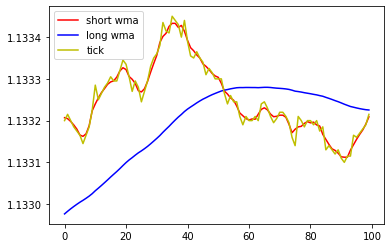

<Figure size 1440x720 with 0 Axes>

In [40]:
short_wma_list, long_wma_list, tick_list = run_wma(short_moving_window = 5, long_moving_window = 100)
plt.plot(short_wma_list, 'r' ,label="short wma")
plt.plot(long_wma_list,'b' ,label="long wma")
plt.plot(tick_list, 'y' ,label="tick")
plt.legend(loc="upper left")
plt.figure(figsize=(20,10)) 
plt.show()

In [22]:
'''
%%time
#num = 25
num = get_min_trans_num(instrument, accountID, iter_num, pip_gap, pip_size)
dir_min_trans_num_long = round((num * dir_min_trans_multiplier_long),0)
dir_min_trans_num_short = round((num * dir_min_trans_multiplier_short),0)
dir_min_trans_num = dir_min_trans_num_long

run_min_trans_num = round((num * run_min_trans_multiplier),0)

run_flag = True

for i in range(num_of_bets):    
    print(f'-------------------------------Iteration {i+1}-------------------------------')
    if run_flag:
        direction, df_reached_targets, tick_list = run_direction_engine(accountID, instrument, dir_min_trans_num, target_num, min_count, pip_size, pip_gap, min_count_mulitplier)    
        print('df_reached_targets : ',df_reached_targets)
        
    if direction == 'no_direction':
        print('no_direction : Run again')
        run_flag = True
        dir_min_trans_num = dir_min_trans_num_long
        output_df = get_output_data('', '', '', '', '', '',dirc = False) 
        
    else:
        print(f'Direction : {direction}')
        make_order_log, close_order_log, iters, close_reason = run_order_engine(accountID, instrument, direction, profit_target_num, loss_limit_num, price_allowed_buffer, run_min_trans_num, pip_size, loss_limits)
        output_df = get_output_data(accountID, instrument, make_order_log, close_order_log, iters, close_reason, dirc = True)
        pl_pip = float(output_df['profit_pips'])
        iter_limit = dir_min_trans_num * dir_recalc_multiplier
        print(f'pl:{pl_pip} iter_limit:{iter_limit}')


        if float(pl_pip) >= 0 and iters < iter_limit:
            run_flag = True
            dir_min_trans_num = dir_min_trans_num_short
        else:
            run_flag = True
            dir_min_trans_num = dir_min_trans_num_long

    output_df.to_csv('data/machine_use/output_log_machine_use.csv', mode='a', header=False, index = False)
'''

"\n%%time\n#num = 25\nnum = get_min_trans_num(instrument, accountID, iter_num, pip_gap, pip_size)\ndir_min_trans_num_long = round((num * dir_min_trans_multiplier_long),0)\ndir_min_trans_num_short = round((num * dir_min_trans_multiplier_short),0)\ndir_min_trans_num = dir_min_trans_num_long\n\nrun_min_trans_num = round((num * run_min_trans_multiplier),0)\n\nrun_flag = True\n\nfor i in range(num_of_bets):    \n    print(f'-------------------------------Iteration {i+1}-------------------------------')\n    if run_flag:\n        direction, df_reached_targets, tick_list = run_direction_engine(accountID, instrument, dir_min_trans_num, target_num, min_count, pip_size, pip_gap, min_count_mulitplier)    \n        print('df_reached_targets : ',df_reached_targets)\n        \n    if direction == 'no_direction':\n        print('no_direction : Run again')\n        run_flag = True\n        dir_min_trans_num = dir_min_trans_num_long\n        output_df = get_output_data('', '', '', '', '', '',dirc = Fal

In [23]:
'''
df_copy = pd.read_csv('data/machine_use/output_log_machine_use.csv')
df_copy.to_csv('data/output_log.csv', index = False)    
'''

"\ndf_copy = pd.read_csv('data/machine_use/output_log_machine_use.csv')\ndf_copy.to_csv('data/output_log.csv', index = False)    \n"